In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

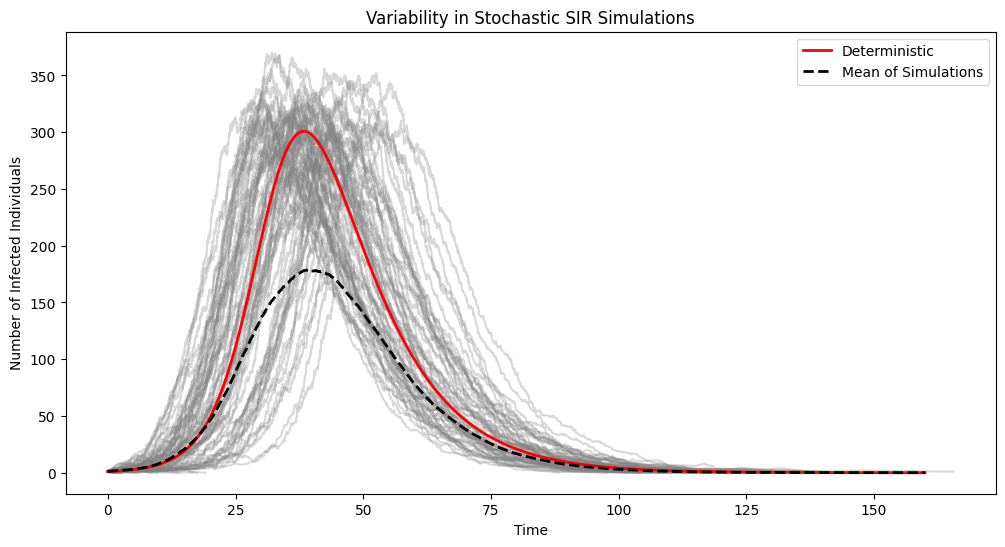

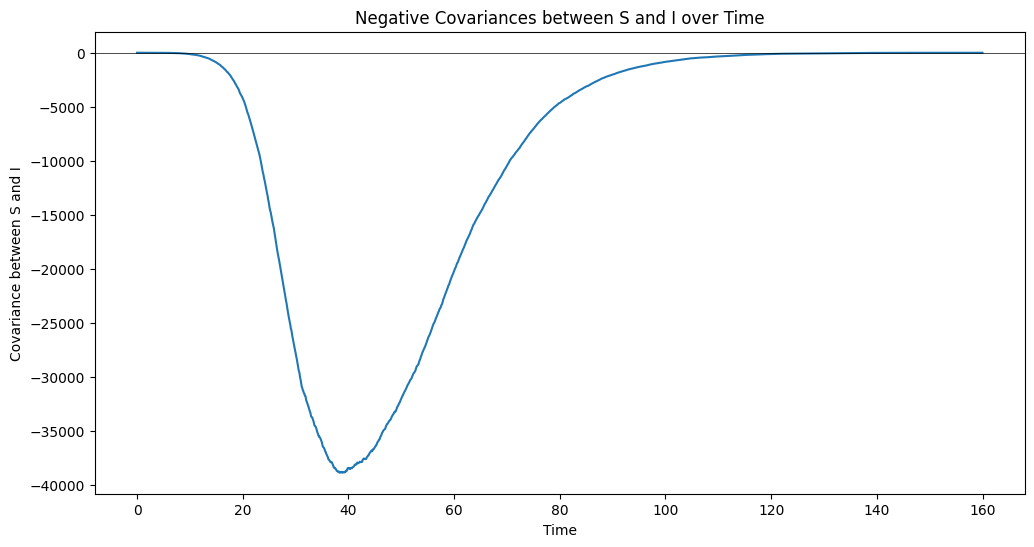

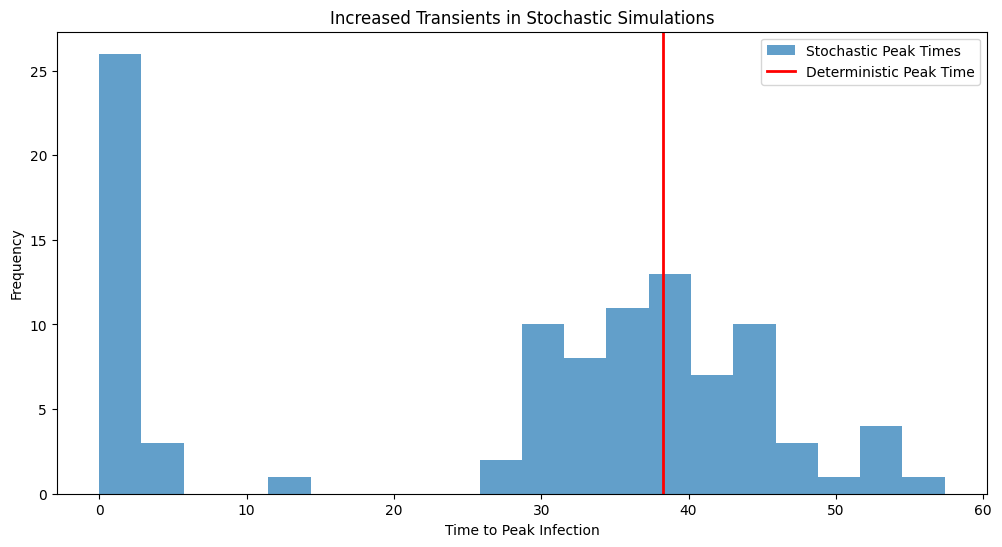

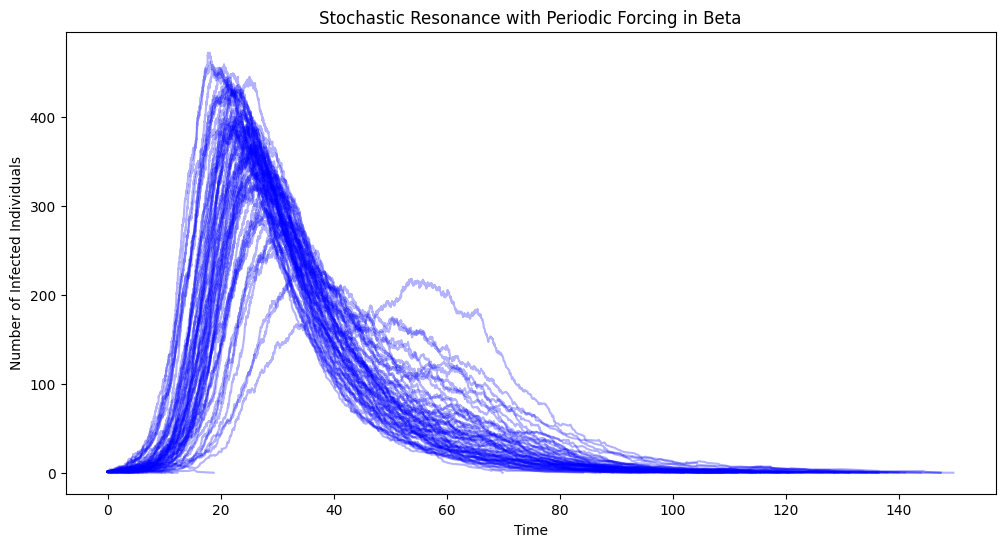

Number of extinctions out of 100 simulations: 99


In [3]:
# Parameters
beta = 0.3      # Transmission rate
gamma = 0.1     # Recovery rate
N = 1000        # Total population
num_simulations = 100  # Number of stochastic simulations
t_max = 160     # Maximum time

# Time points for deterministic solution
t_det = np.linspace(0, t_max, 1000)

# Initial conditions
S0 = N - 1
I0 = 1
R0 = 0

# Function to run a single Gillespie simulation
def gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        # Calculate rates
        a1 = beta * S * I / N     # Infection rate
        a2 = gamma * I            # Recovery rate
        a0 = a1 + a2              # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Function for deterministic SIR model
def SIR_ode(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Solve deterministic SIR model
y0 = [S0, I0, R0]
ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
S_det, I_det, R_det = ret.T

# Lists to store multiple simulation results
I_values = []
S_values = []
R_values = []
time_values = []

# Run multiple Gillespie simulations
for sim in range(num_simulations):
    times, S_vals, I_vals, R_vals = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
    I_values.append(I_vals)
    S_values.append(S_vals)
    R_values.append(R_vals)
    time_values.append(times)

# Align data for statistical analysis
max_len = max(len(tv) for tv in time_values)
time_grid = np.linspace(0, t_max, max_len)

I_interp = np.zeros((num_simulations, max_len))
S_interp = np.zeros((num_simulations, max_len))
R_interp = np.zeros((num_simulations, max_len))

for i in range(num_simulations):
    I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
    S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])
    R_interp[i, :] = np.interp(time_grid, time_values[i], R_values[i])

# Compute statistics
I_mean = np.mean(I_interp, axis=0)
I_var = np.var(I_interp, axis=0)
S_mean = np.mean(S_interp, axis=0)
S_var = np.var(S_interp, axis=0)
cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)

# Plotting results

# 1. Variability: Plot multiple stochastic simulations and compare with deterministic solution
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Variability in Stochastic SIR Simulations')
plt.legend()
plt.show()

# 2. Negative Covariances: Plot covariance between S and I over time
plt.figure(figsize=(12, 6))
plt.plot(time_grid, cov_SI)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Negative Covariances between S and I over Time')
plt.axhline(0, color='black', lw=0.5)
plt.show()

# 3. Increased Transients: Compare the time to reach peak infection
peak_time_det = t_det[np.argmax(I_det)]
peak_times_stoch = [time_values[i][np.argmax(I_values[i])] for i in range(num_simulations)]

plt.figure(figsize=(12, 6))
plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
plt.xlabel('Time to Peak Infection')
plt.ylabel('Frequency')
plt.title('Increased Transients in Stochastic Simulations')
plt.legend()
plt.show()

# 4. Stochastic Resonance: Introduce periodic forcing in beta
def beta_time(t, beta0, amplitude, frequency):
    return beta0 * (1 + amplitude * np.sin(2 * np.pi * frequency * t))

# Modify the Gillespie function to accept time-dependent beta
def gillespie_SIR_forced(beta_func, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        current_beta = beta_func(t)
        a1 = current_beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Parameters for periodic forcing
amplitude = 0.5
frequency = 1/50  # One oscillation every 50 time units

# Run multiple simulations with periodic forcing
I_values_forced = []
time_values_forced = []

for sim in range(num_simulations):
    times_f, _, I_vals_f, _ = gillespie_SIR_forced(
        lambda t: beta_time(t, beta, amplitude, frequency), gamma, N, S0, I0, R0, t_max)
    I_values_forced.append(I_vals_f)
    time_values_forced.append(times_f)

# Plotting the effect of stochastic resonance
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values_forced[i], I_values_forced[i], color='blue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Stochastic Resonance with Periodic Forcing in Beta')
plt.show()

# 5. Extinctions: Count the number of simulations where the disease goes extinct
extinctions = sum(1 for I_vals in I_values if I_vals[-1] == 0)
print(f'Number of extinctions out of {num_simulations} simulations: {extinctions}')


In [4]:
# Function to run a single Gillespie simulation
def gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        # Calculate rates
        a1 = beta * S * I / N     # Infection rate
        a2 = gamma * I            # Recovery rate
        a0 = a1 + a2              # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Function for deterministic SIR model
def SIR_ode(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


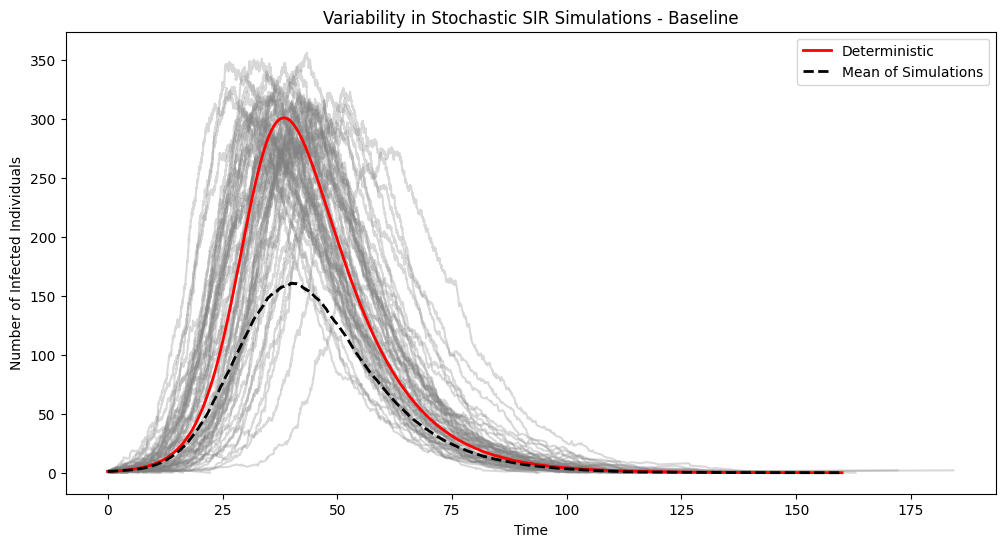

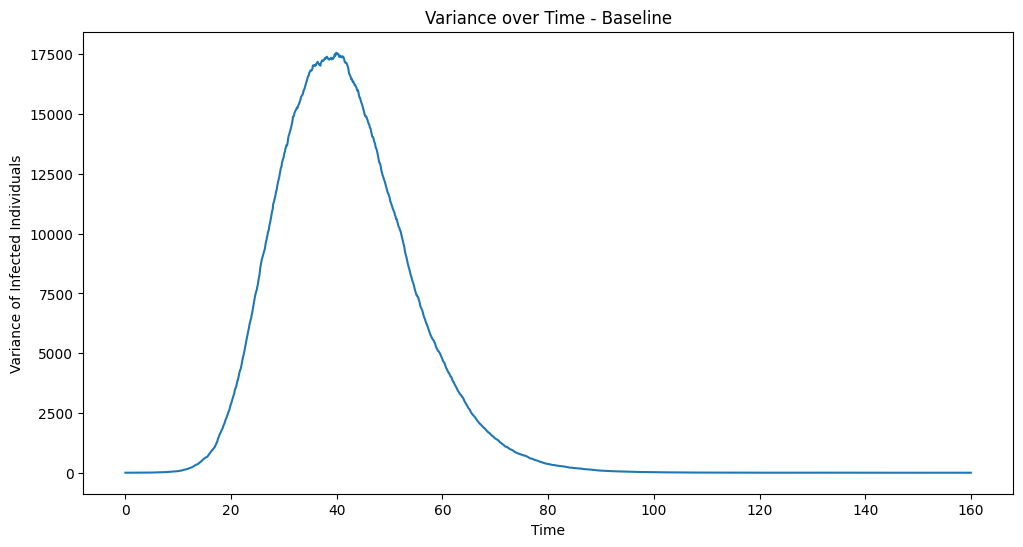

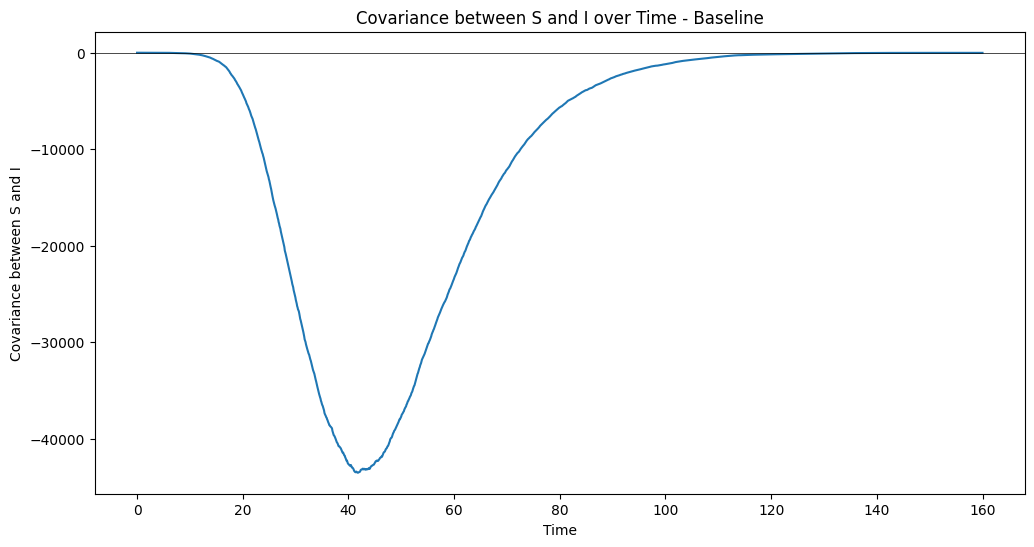

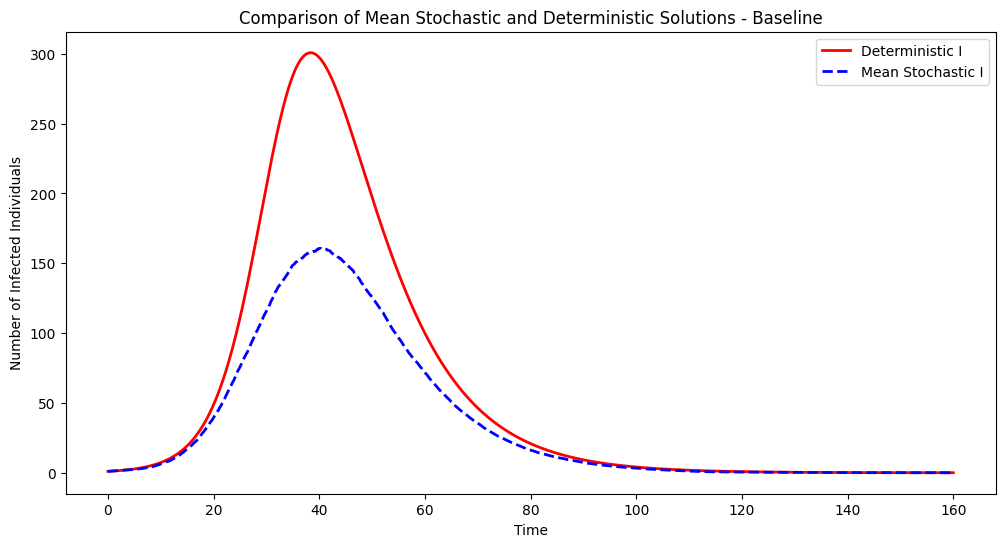

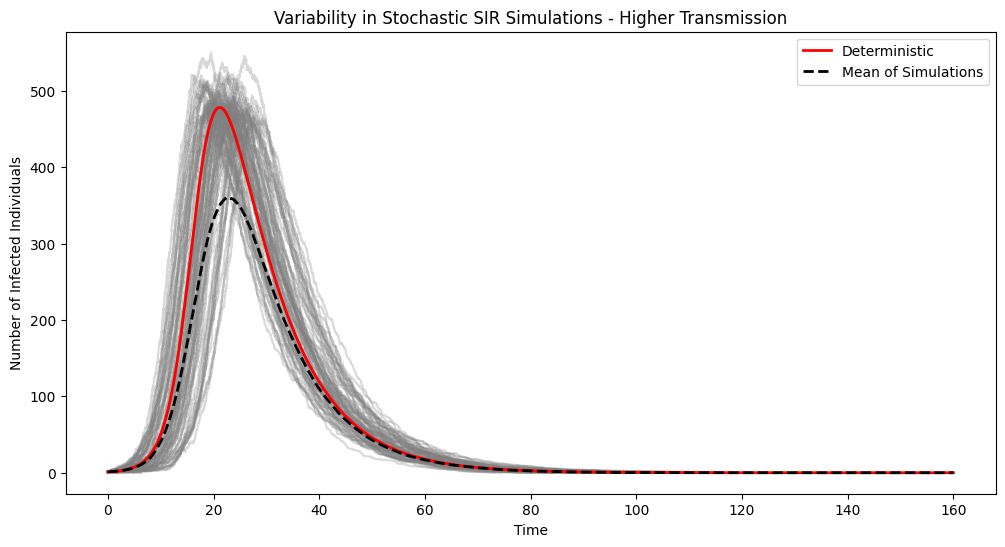

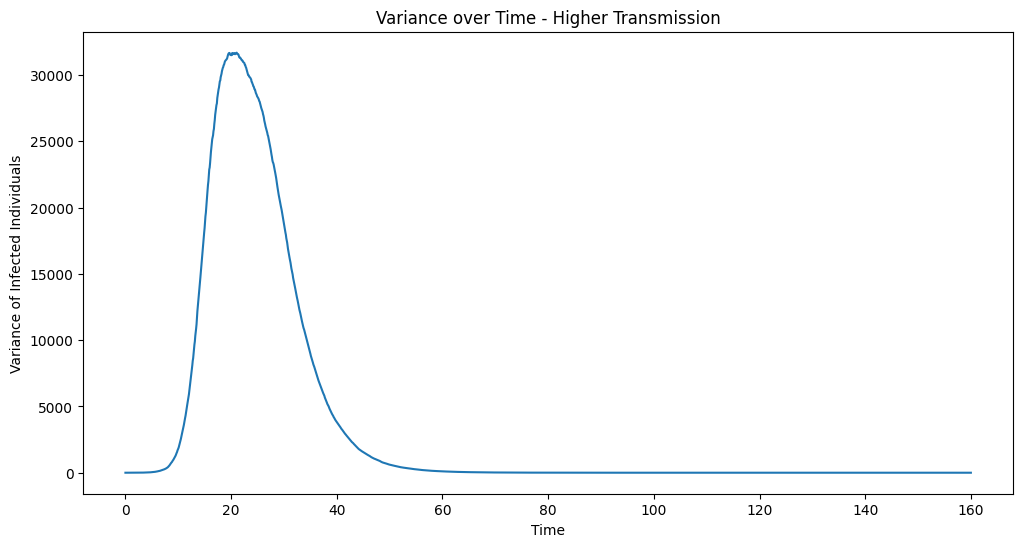

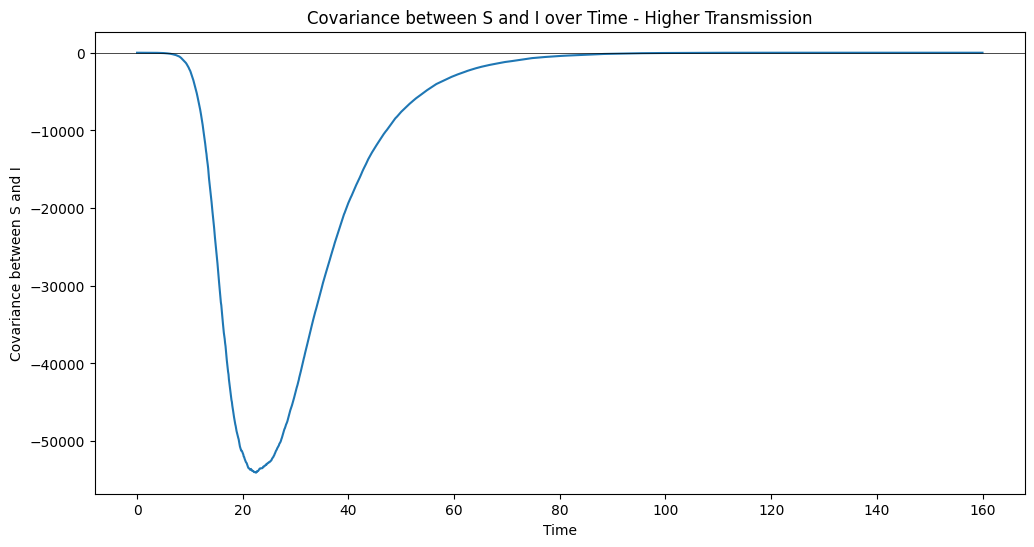

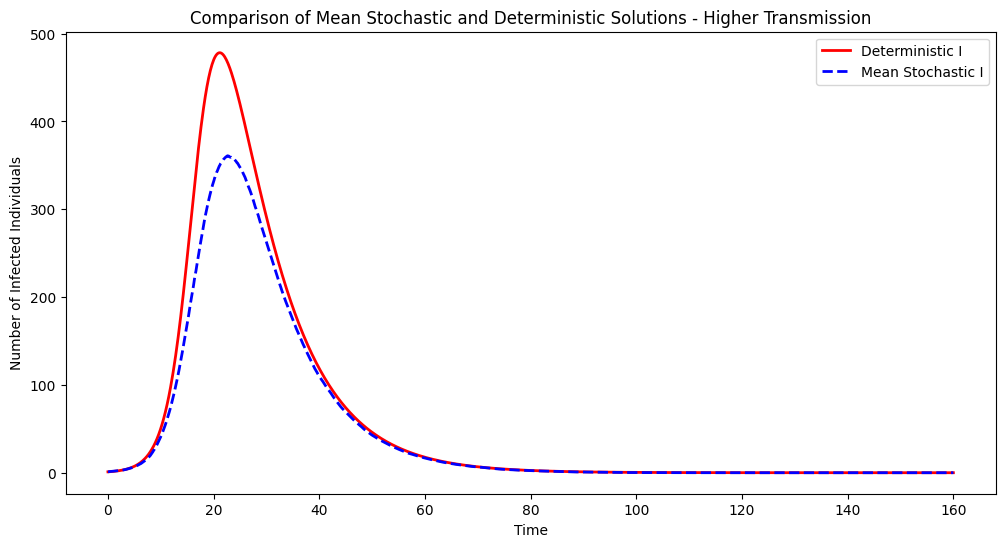

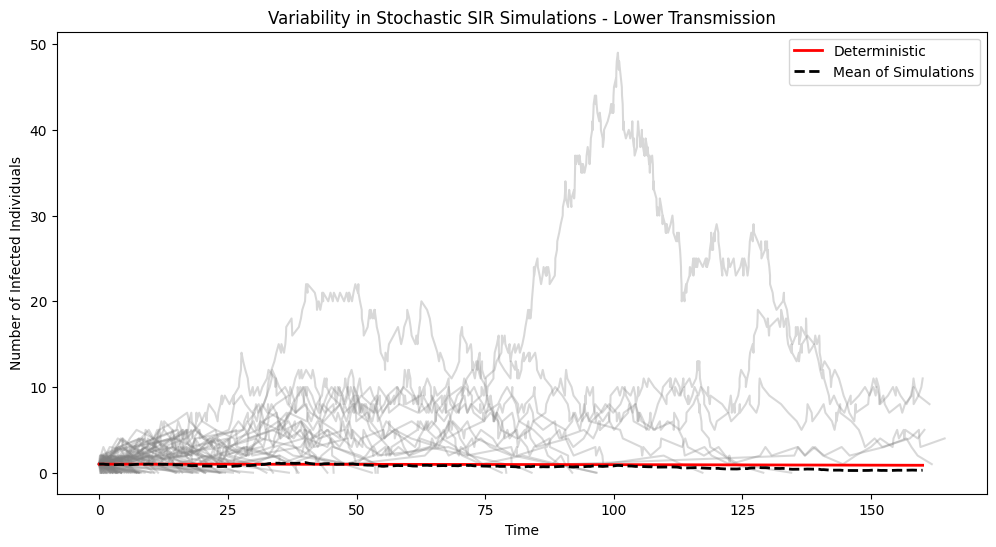

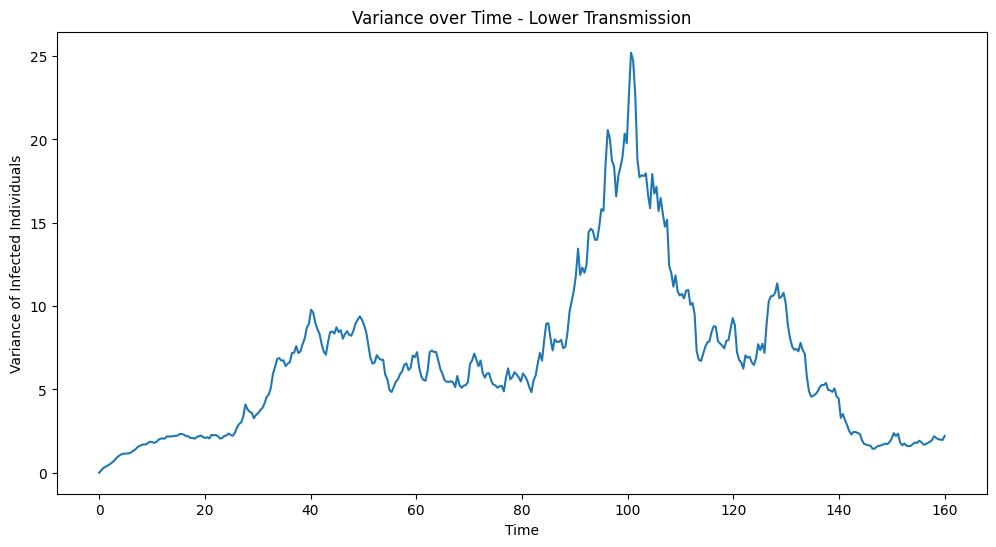

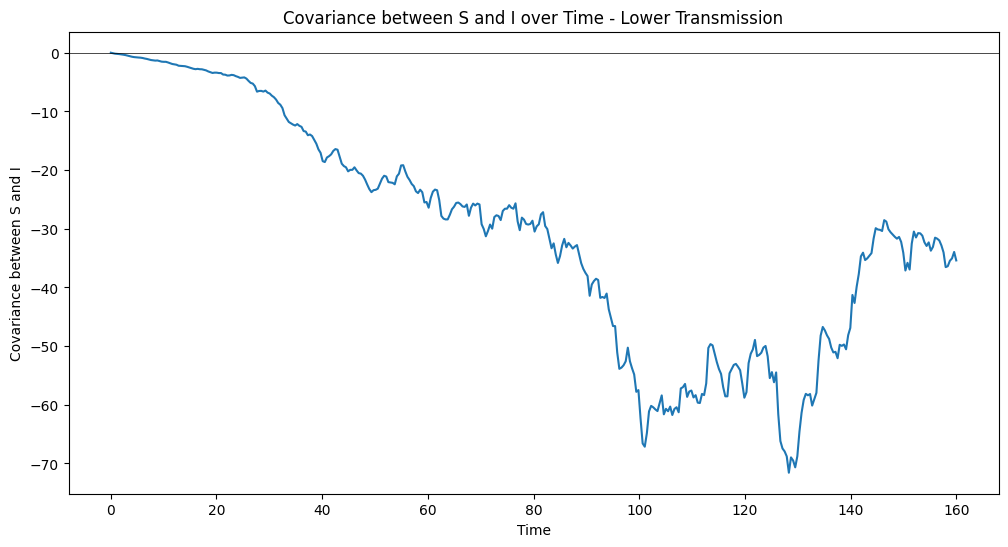

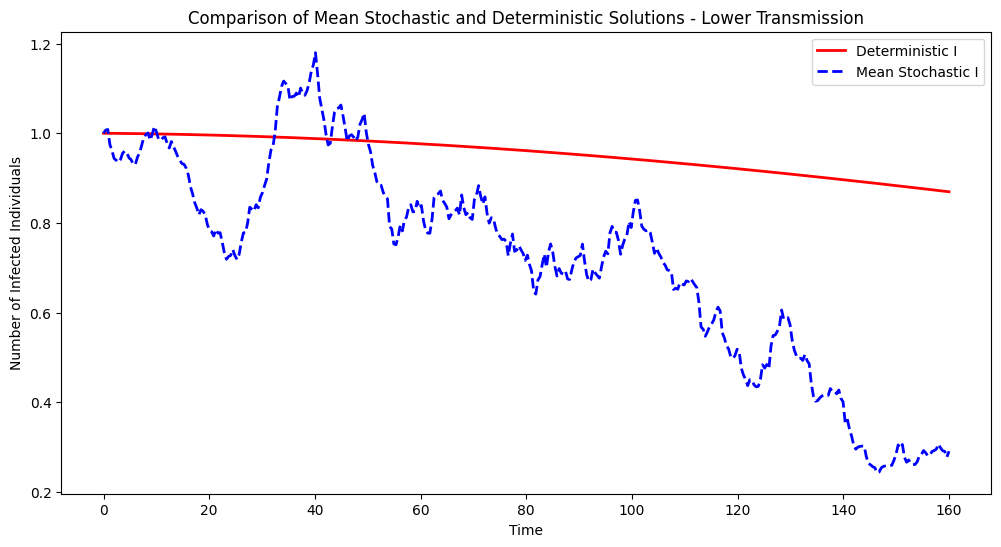

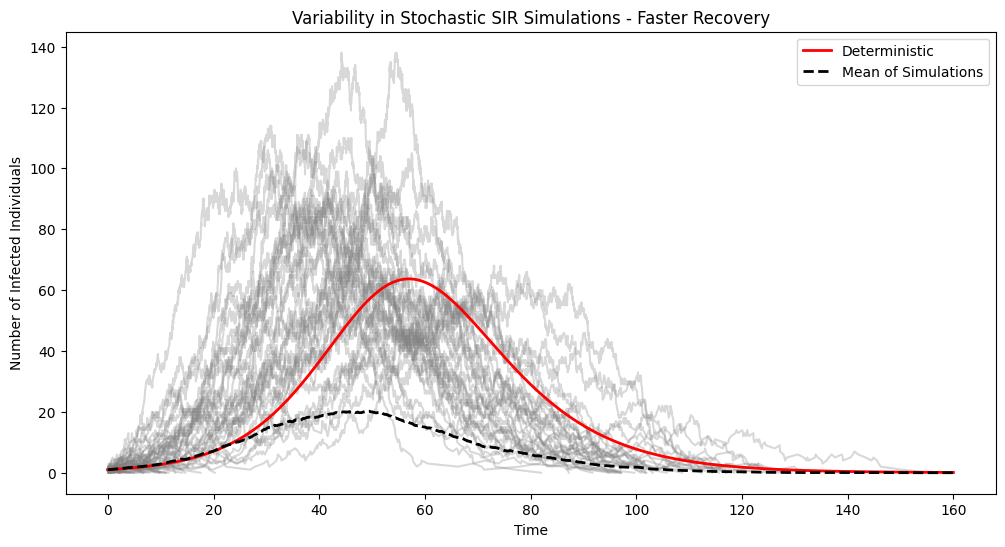

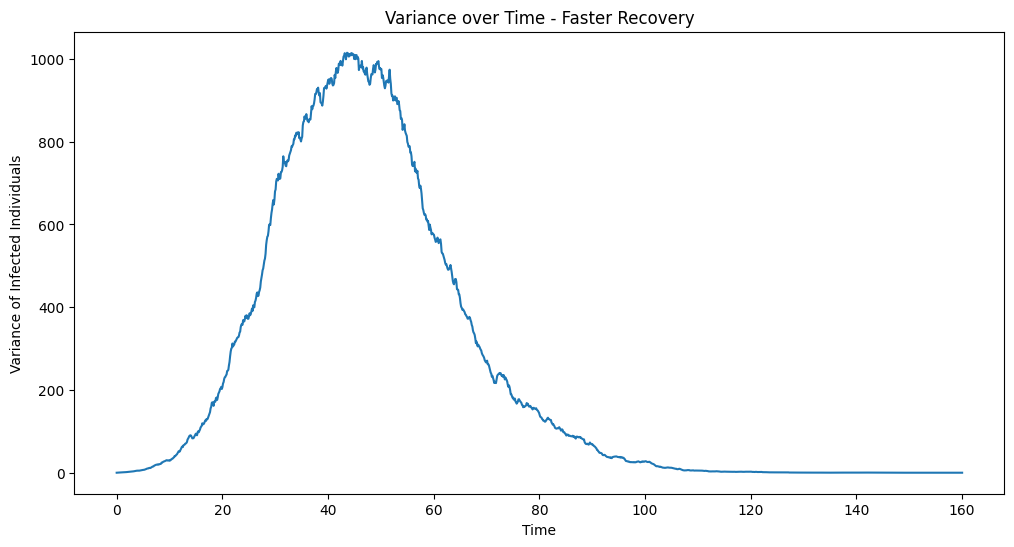

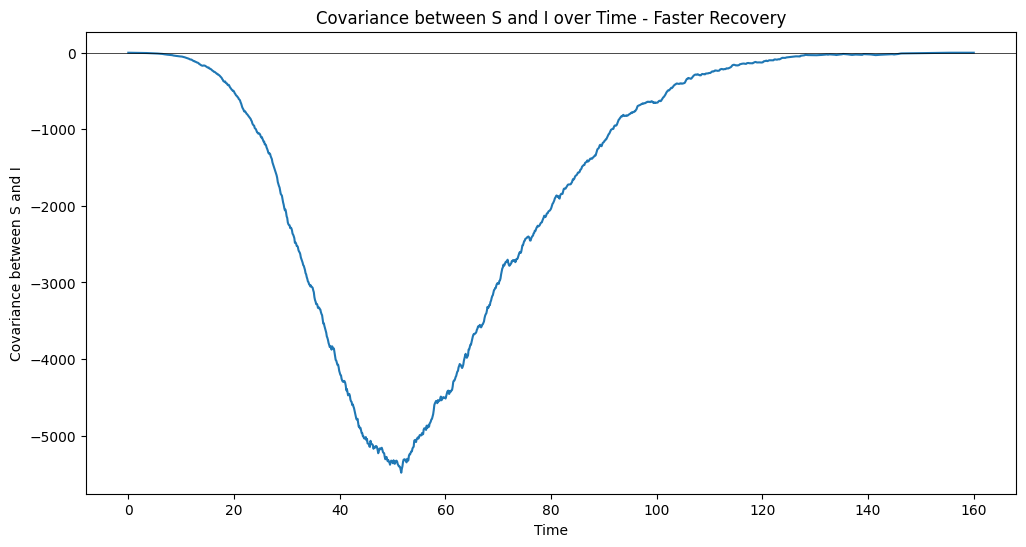

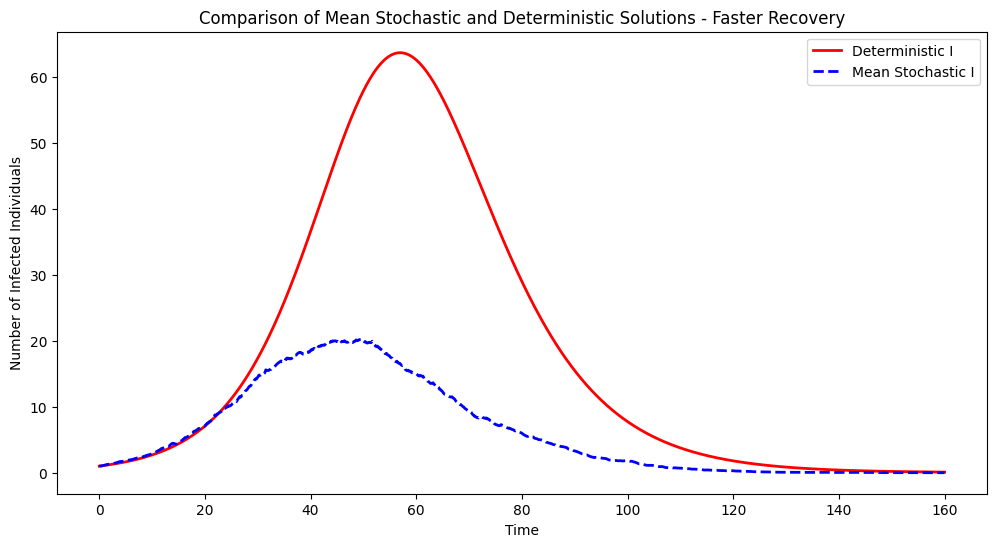

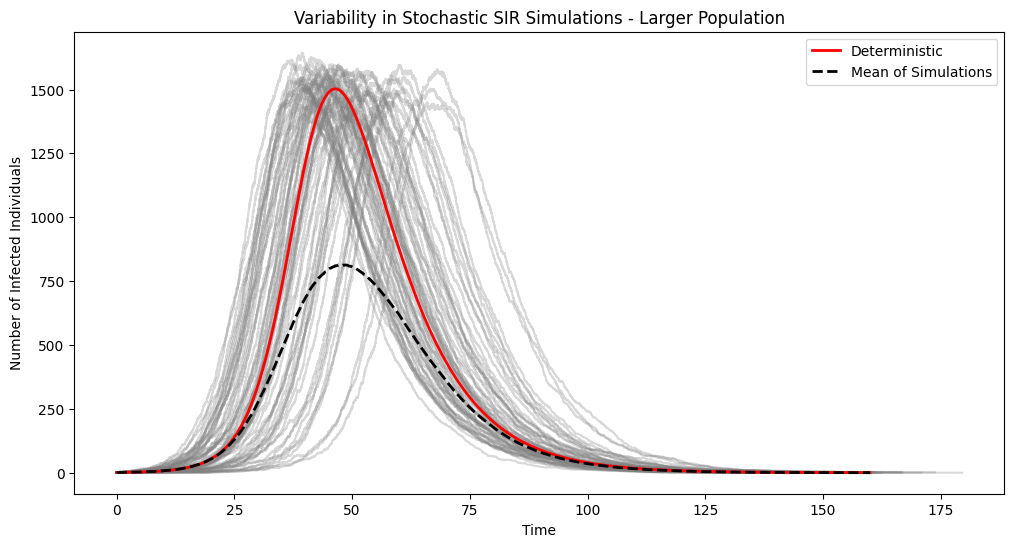

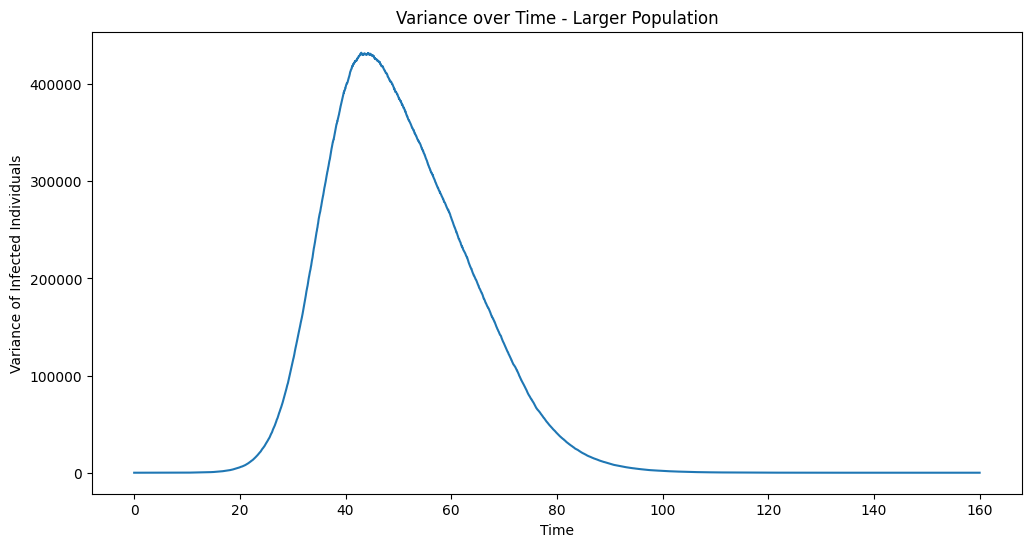

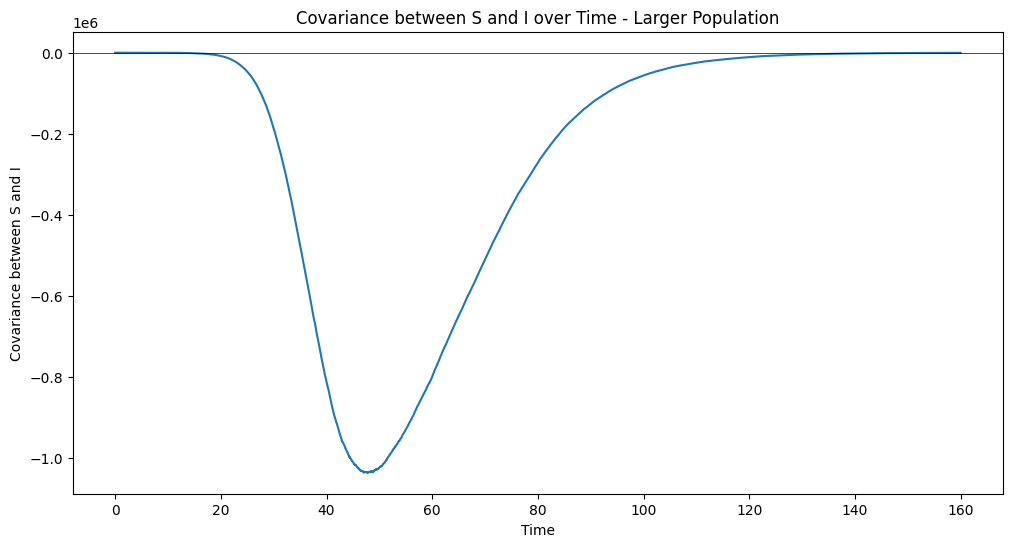

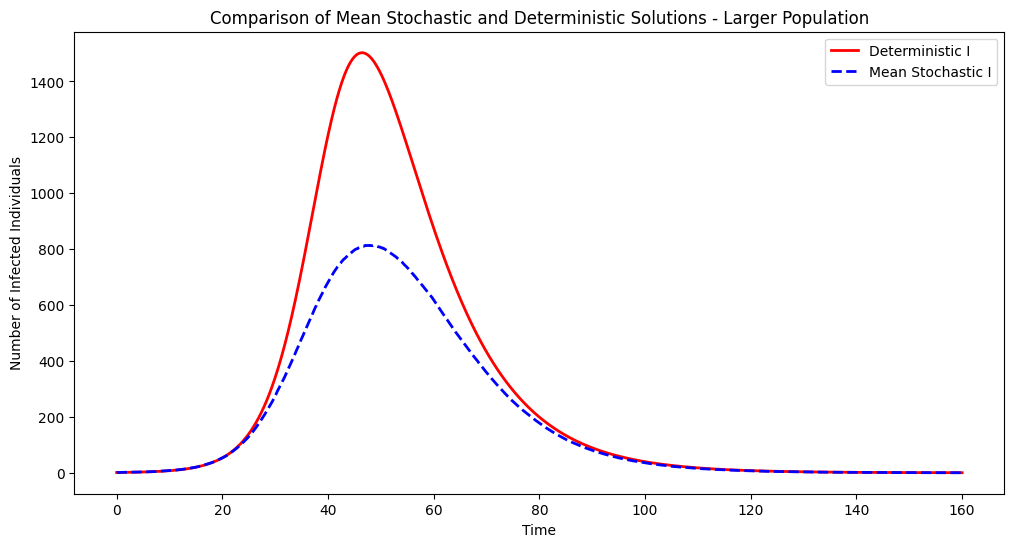

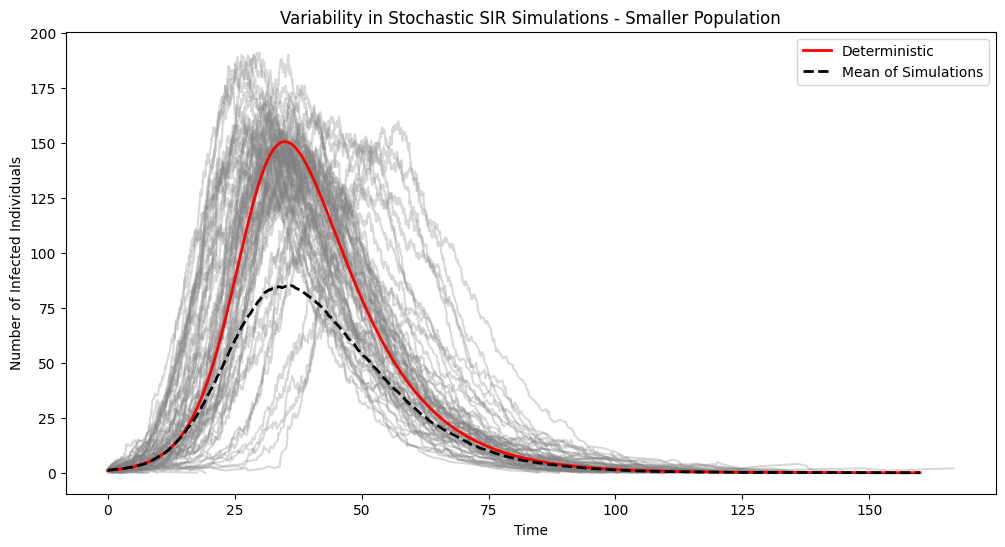

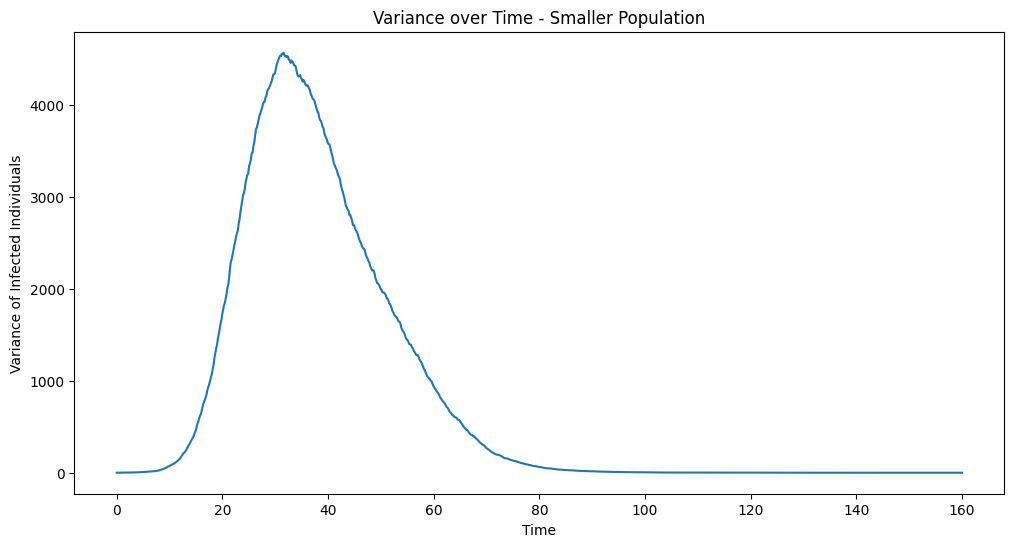

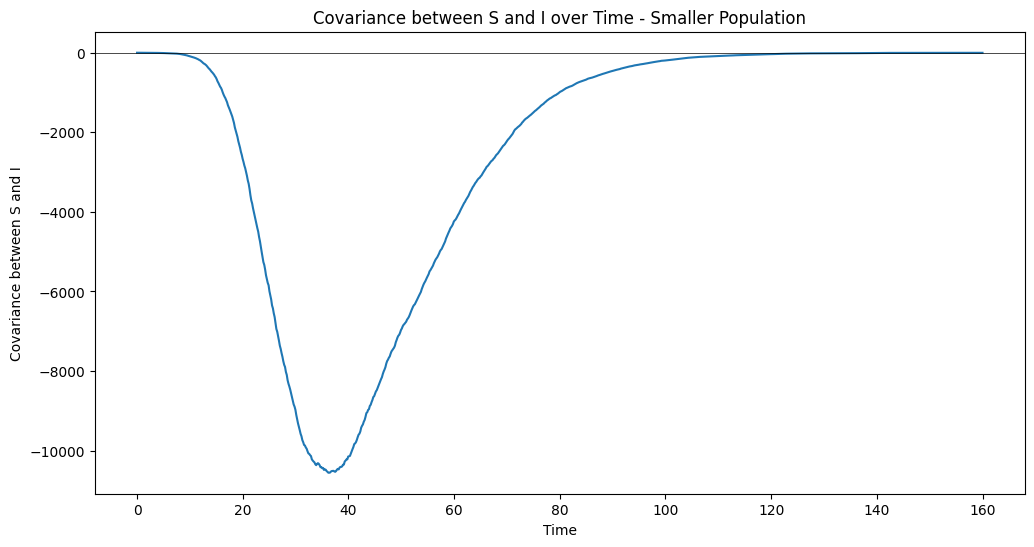

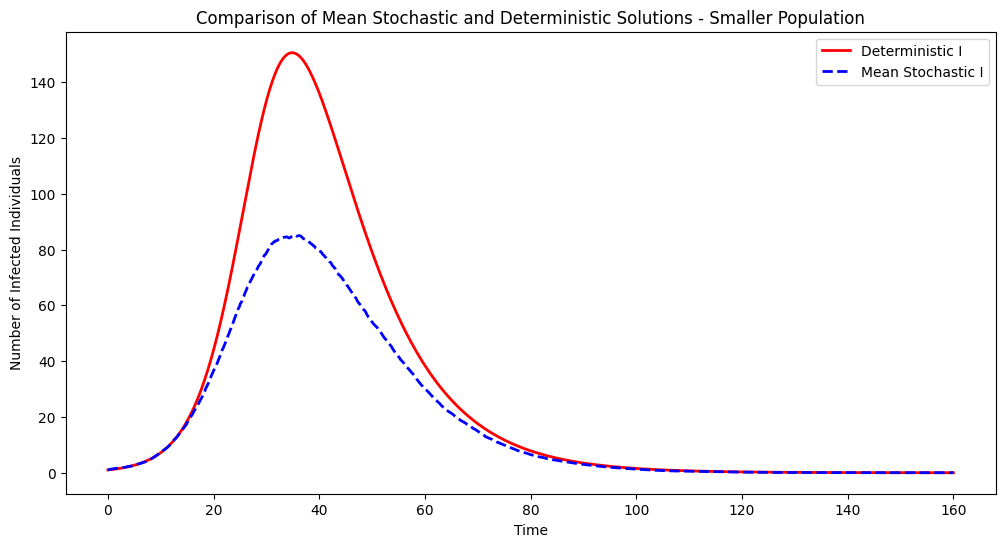

In [5]:
# Parameter sets
parameter_sets = [
    {'beta': 0.3, 'gamma': 0.1, 'N': 1000, 'label': 'Baseline'},
    {'beta': 0.5, 'gamma': 0.1, 'N': 1000, 'label': 'Higher Transmission'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'Lower Transmission'},
    {'beta': 0.3, 'gamma': 0.2, 'N': 1000, 'label': 'Faster Recovery'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 5000, 'label': 'Larger Population'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 500, 'label': 'Smaller Population'}
]

num_simulations = 100  # Number of stochastic simulations
t_max = 160  # Maximum time
t_det = np.linspace(0, t_max, 1000)  # Time points for deterministic solution

# Loop over parameter sets
for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    
    S0 = N - 1
    I0 = 1
    R0 = 0

    # Solve deterministic SIR model
    y0 = [S0, I0, R0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T

    # Lists to store multiple simulation results
    I_values = []
    S_values = []
    time_values = []

    # Run multiple stochastic simulations
    for sim in range(num_simulations):
        times, S_vals, I_vals, _ = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
        I_values.append(I_vals)
        S_values.append(S_vals)
        time_values.append(times)

    # Align data for statistical analysis
    max_len = max(len(tv) for tv in time_values)
    time_grid = np.linspace(0, t_max, max_len)

    I_interp = np.zeros((num_simulations, max_len))
    S_interp = np.zeros((num_simulations, max_len))

    for i in range(num_simulations):
        I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
        S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])

    # Compute statistics
    I_mean = np.mean(I_interp, axis=0)
    I_var = np.var(I_interp, axis=0)
    S_mean = np.mean(S_interp, axis=0)
    S_var = np.var(S_interp, axis=0)
    cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)

    # Plotting results

    # Plot multiple stochastic simulations and deterministic solution
    plt.figure(figsize=(12, 6))
    for i in range(num_simulations):
        plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
    plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Variability in Stochastic SIR Simulations - {label}')
    plt.legend()
    plt.show()

    # Plot variance of I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, I_var)
    plt.xlabel('Time')
    plt.ylabel('Variance of Infected Individuals')
    plt.title(f'Variance over Time - {label}')
    plt.show()

    # Plot covariance between S and I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, cov_SI)
    plt.xlabel('Time')
    plt.ylabel('Covariance between S and I')
    plt.title(f'Covariance between S and I over Time - {label}')
    plt.axhline(0, color='black', lw=0.5)
    plt.show()

    # Comparison of mean stochastic and deterministic solutions
    plt.figure(figsize=(12, 6))
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic I')
    plt.plot(time_grid, I_mean, 'b--', lw=2, label='Mean Stochastic I')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Comparison of Mean Stochastic and Deterministic Solutions - {label}')
    plt.legend()
    plt.show()

    # Additional analysis and plots can be added here


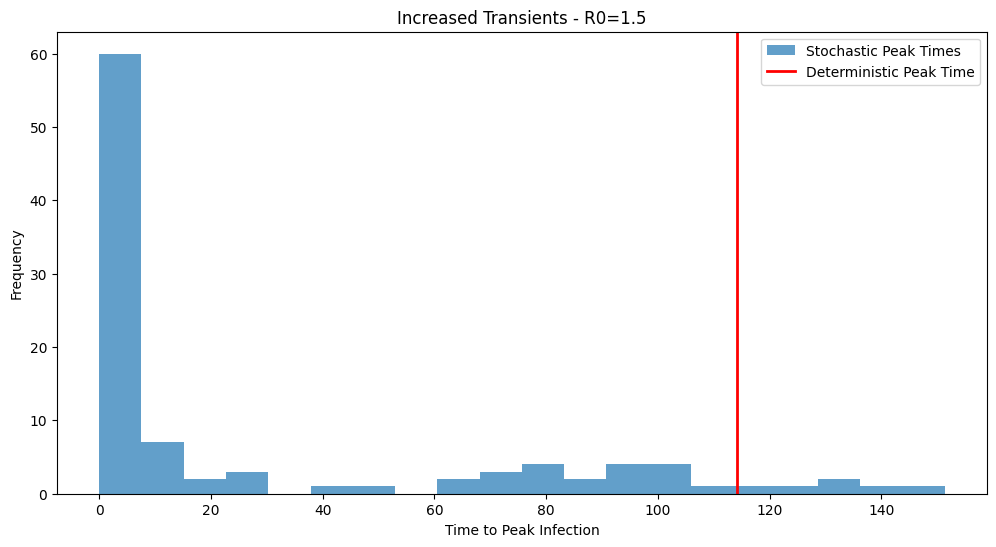

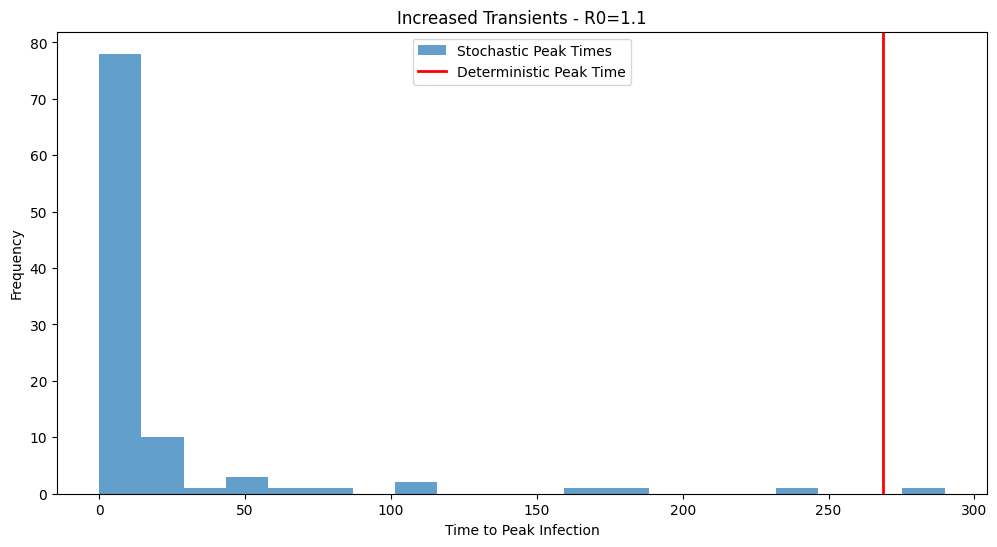

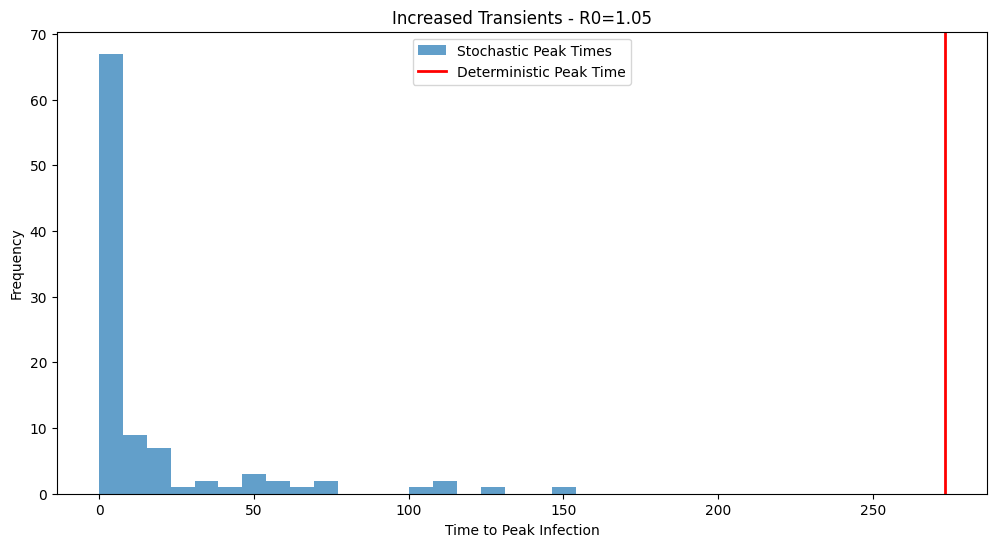

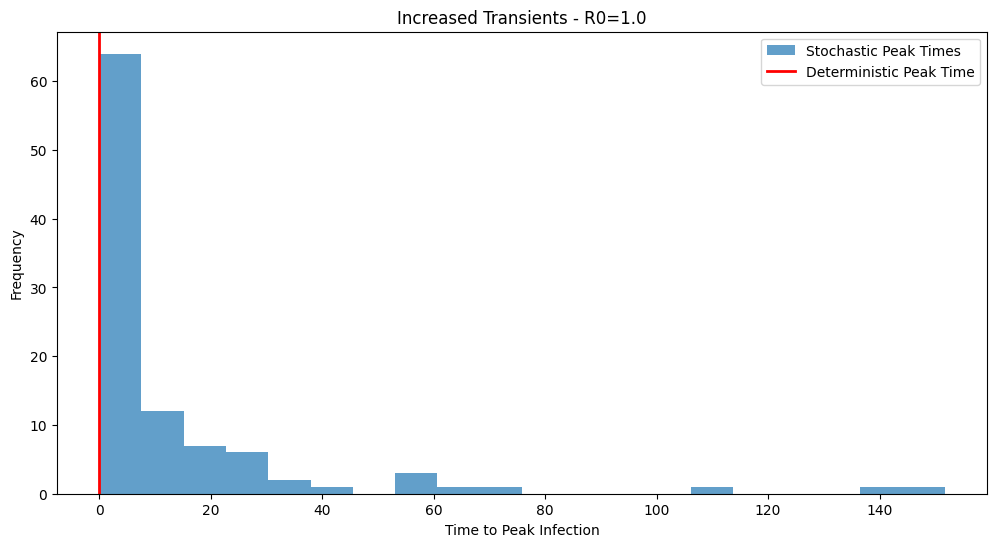

In [6]:
# Function to run Gillespie simulation and record peak time
def gillespie_SIR_peak_time(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    I_vals = [I]
    peak_I = I
    peak_time = t

    while t < t_max and I > 0:
        a1 = beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        I_vals.append(I)

        if I > peak_I:
            peak_I = I
            peak_time = t

    return np.array(times), np.array(I_vals), peak_time

parameter_sets = [
    {'beta': 0.15, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.5'},
    {'beta': 0.11, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.1'},
    {'beta': 0.105, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.05'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.0'},
]

num_simulations = 100
t_max = 500
I0 = 1

for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    S0 = N - I0

    # Solve deterministic model
    t_det = np.linspace(0, t_max, 1000)
    y0 = [S0, I0, 0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T
    peak_time_det = t_det[np.argmax(I_det)]

    peak_times_stoch = []
    I_values = []
    time_values = []

    for sim in range(num_simulations):
        times, I_vals, peak_time = gillespie_SIR_peak_time(beta, gamma, N, S0, I0, 0, t_max)
        peak_times_stoch.append(peak_time)
        I_values.append(I_vals)
        time_values.append(times)

    # Plot histogram of peak times
    plt.figure(figsize=(12, 6))
    plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
    plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
    plt.xlabel('Time to Peak Infection')
    plt.ylabel('Frequency')
    plt.title(f'Increased Transients - {label}')
    plt.legend()
    plt.show()


In [ ]:
# Gillespie algorithm function to check for extinction
def gillespie_SIR_extinction(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    while t < t_max:
        if I == 0:
            # Extinction occurred
            return True
        # Calculate rates
        a1 = beta * S * I / N  # Infection rate
        a2 = gamma * I         # Recovery rate
        a0 = a1 + a2           # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

    # If simulation ends without I reaching 0, extinction did not occur
    return False

# Parameters
gamma = 0.1  # Fixed recovery rate
t_max = 500
n_simulations = 1000  # Number of simulations per parameter set
I0 = 1  # Initial number of infected individuals

# R0 and N values to test
R0_values = np.linspace(1.0, 1.75, 21)  # From 1.0 to 3.0 in steps of 0.1
N_values = [500, 1000, 5000, 10000]

# Store results
extinction_probabilities = {}

for N in N_values:
    extinction_probabilities[N] = []
    S0 = N - I0
    for R0 in R0_values:
        beta = R0 * gamma  # Adjust beta to get desired R0
        extinctions = 0
        for _ in range(n_simulations):
            extinct = gillespie_SIR_extinction(beta, gamma, N, S0, I0, 0, t_max)
            if extinct:
                extinctions += 1
        P_extinct = extinctions / n_simulations
        extinction_probabilities[N].append(P_extinct)
        print(f"N={N}, R0={R0:.2f}, Extinction Probability={P_extinct:.3f}")

# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()


N=500, R0=1.00, Extinction Probability=1.000
N=500, R0=1.04, Extinction Probability=1.000
N=500, R0=1.07, Extinction Probability=1.000
N=500, R0=1.11, Extinction Probability=1.000
N=500, R0=1.15, Extinction Probability=1.000
N=500, R0=1.19, Extinction Probability=1.000
N=500, R0=1.23, Extinction Probability=1.000
N=500, R0=1.26, Extinction Probability=1.000
N=500, R0=1.30, Extinction Probability=1.000
N=500, R0=1.34, Extinction Probability=1.000
N=500, R0=1.38, Extinction Probability=1.000
N=500, R0=1.41, Extinction Probability=1.000
N=500, R0=1.45, Extinction Probability=1.000
N=500, R0=1.49, Extinction Probability=1.000
N=500, R0=1.52, Extinction Probability=1.000
N=500, R0=1.56, Extinction Probability=1.000
N=500, R0=1.60, Extinction Probability=1.000
N=500, R0=1.64, Extinction Probability=1.000
N=500, R0=1.67, Extinction Probability=1.000
N=500, R0=1.71, Extinction Probability=1.000
N=500, R0=1.75, Extinction Probability=1.000
N=1000, R0=1.00, Extinction Probability=1.000
N=1000, R